<a href="https://colab.research.google.com/github/a4meen/Code-Lab-ML/blob/main/M_Ameen_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from sklearn import model_selection, datasets, linear_model, svm, tree, metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.model_selection import train_test_split
from random import randrange


In [2]:
tf.random.set_seed(42)

#Import Data & Preprocessing


In [3]:
images = []
labels = []

path = '/content/drive/MyDrive/Rock-Paper-Scissors'

labels_dict = {"paper" : 0, "rock" : 1,"scissors" : 2}
labels_dict_rev = {0 : "paper",  1 : "rock" ,2 : "scissors"}


for file in os.listdir(path):
    
    if file in labels_dict.keys():
        
        for img_path in os.listdir(os.path.join(path, file)):
            
            img = image.load_img(os.path.join(path, file, img_path), target_size=(254,254))#, color_mode="grayscale")
            img = image.img_to_array(img)/255.0
            
            images.append(img)
            labels.append(labels_dict[file])

images = np.array(images)
labels = np.array(labels)

##Splitting Data into trainning & testing


In [4]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels, shuffle = True)

(<matplotlib.image.AxesImage at 0x7f4fc7ea8cd0>, 1)

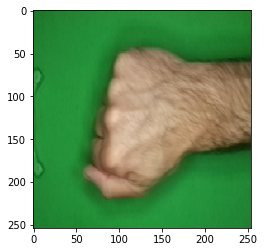

In [5]:
mm = 0

plt.imshow(np.reshape(np.array(x_train[mm]),(254,254,3))),y_train[mm]#,cmap='gray')

In [6]:
y_train_onehot = tf.one_hot(y_train,3)
y_test_onehot = tf.one_hot(y_test,3)

In [7]:
x_train.shape, x_test.shape, y_train_onehot.shape, y_test_onehot.shape

((1752, 254, 254, 3),
 (438, 254, 254, 3),
 TensorShape([1752, 3]),
 TensorShape([438, 3]))

##Data Agumentation & Creation


In [8]:
def augment_image(image, label):        ## Function for data agumentation
  
  image = tf.image.random_flip_left_right(image) # Randomly flip an image horizontally
  image = tf.image.random_flip_up_down(image) # Randomly flips an image vertically
  image = tf.image.random_brightness(image, max_delta=32.0/255.0) # Adjust the brightness of images by a random factor
  #image = tf.image.random_saturation(image, lower=0.5, upper=1.5) # Adjust the saturation of RGB images by a random factor
    
  # Make sure the image's pixel values are still between 0 and 1
  image = tf.clip_by_value(image, 0.0, 1.0)
    
  return image, label



def dataset_creater(x, y, batch_size=32, training=False):     ##Function for data creation

  data = tf.data.Dataset.from_tensor_slices((x,y))

  if training:
    data = data.map(augment_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) # Applying the augment_image function on dataset

  data = data.shuffle(1024) # Shuffle the data
  data = data.batch(batch_size) # Create mini-batches for the specified size

  # This allows later elements to be prepared while the current element is being processed.
  data = data.prefetch(tf.data.experimental.AUTOTUNE)

  return data

In [9]:
train_data = dataset_creater(x_train,y_train_onehot, training=True)
test_data = dataset_creater(x_test, y_test_onehot)


In [10]:
train_data,test_data

(<PrefetchDataset shapes: ((None, 254, 254, 3), (None, 3)), types: (tf.float32, tf.float32)>,
 <PrefetchDataset shapes: ((None, 254, 254, 3), (None, 3)), types: (tf.float32, tf.float32)>)

#Model 1 / CNN

In [37]:
# Setting Model Layers

cnn_sys = tf.keras.Sequential([   ### kernal size 1
                               tf.keras.layers.Input([254,254,3]),          ### must increasing(smoothly) filters do not decrease
                               tf.keras.layers.BatchNormalization(),
                               tf.keras.layers.Conv2D(32,3,1,padding='same',activation=tf.nn.leaky_relu),    ###shape of image square
                               tf.keras.layers.MaxPool2D(),
                               tf.keras.layers.BatchNormalization(),
                               tf.keras.layers.Conv2D(64,3,1,padding='same',activation=tf.nn.leaky_relu),
                               tf.keras.layers.MaxPool2D(),
                               tf.keras.layers.BatchNormalization(),
                               tf.keras.layers.Conv2D(128,3,1,padding='same',activation=tf.nn.leaky_relu),
                               tf.keras.layers.MaxPool2D(),
                               tf.keras.layers.BatchNormalization(),
                               tf.keras.layers.Conv2D(128,3,1,padding='same',activation=tf.nn.leaky_relu),
                               tf.keras.layers.MaxPool2D(),
                               tf.keras.layers.Flatten(),
                               tf.keras.layers.Dense(128, activation=tf.nn.leaky_relu),
                               tf.keras.layers.Dropout(0.3),
                               tf.keras.layers.Dense(64, activation=tf.nn.leaky_relu),
                               tf.keras.layers.Dropout(0.2),
                               

                               tf.keras.layers.Dense(3,activation=tf.nn.softmax),

                              
])
cnn_sys.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_4 (Batch (None, 254, 254, 3)       12        
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 127, 127, 32)      128       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 127, 127, 64)      18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 63, 63, 64)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 63, 63, 64)       

##Compile

In [38]:
cnn_sys.compile(optimizer=tf.optimizers.Adam(),loss=tf.losses.CategoricalCrossentropy(),metrics=['acc'])

##Fitting

In [39]:
cnn_his= cnn_sys.fit(train_data ,epochs=20,batch_size=32,validation_data=test_data)

Epoch 1/20
55/55 [==============================] - 7s 112ms/step - loss: 5.9748 - acc: 0.4032 - val_loss: 0.9418 - val_acc: 0.6050
Epoch 2/20
55/55 [==============================] - 7s 108ms/step - loss: 0.9389 - acc: 0.6845 - val_loss: 2.6747 - val_acc: 0.3607
Epoch 3/20
55/55 [==============================] - 7s 109ms/step - loss: 0.7915 - acc: 0.7607 - val_loss: 3.3006 - val_acc: 0.3584
Epoch 4/20
55/55 [==============================] - 7s 108ms/step - loss: 0.4794 - acc: 0.8758 - val_loss: 3.5880 - val_acc: 0.5479
Epoch 5/20
55/55 [==============================] - 7s 109ms/step - loss: 0.5034 - acc: 0.8825 - val_loss: 2.5638 - val_acc: 0.6416
Epoch 6/20
55/55 [==============================] - 7s 109ms/step - loss: 0.3516 - acc: 0.9067 - val_loss: 1.2642 - val_acc: 0.6872
Epoch 7/20
55/55 [==============================] - 7s 109ms/step - loss: 0.1921 - acc: 0.9493 - val_loss: 1.3426 - val_acc: 0.7854
Epoch 8/20
55/55 [==============================] - 7s 109ms/step - loss: 0.

##Predict and evaluate the accuracy

In [40]:
pred= cnn_sys.predict(x_test)
tf.reduce_mean(tf.metrics.categorical_accuracy(y_test_onehot,pred))


<tf.Tensor: shape=(), dtype=float32, numpy=0.9703196>

##Plot loss & val loss

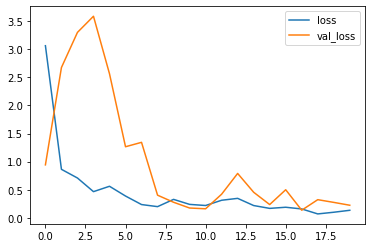

In [41]:
pd.DataFrame(cnn_his.history)[['loss','val_loss']].plot.line()

##Save the model

In [42]:
cnn_sys.save('M_Ameen_RPS.h5')

In [43]:
sys = tf.keras.models.load_model('M_Ameen_RPS.h5', custom_objects={'leaky_relu': tf.nn.leaky_relu})

##Testing

In [44]:
def read_img (img_path):
  img = tf.io.read_file(img_path)
  #img = tf.image.rgb_to_grayscale(img)
  img = tf.image.decode_image(img,channels=1)
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = tf.image.resize(img, [128,128])
  return img

<IPython.core.display.Javascript object>

Saved to photo.jpg


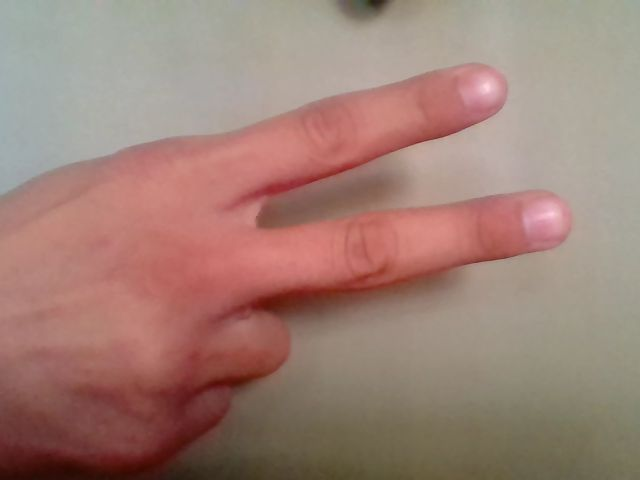

paper
9.423456587997742e-21 %


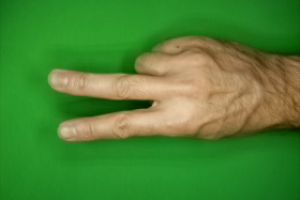

In [46]:
#@title Capturing Photo 1 { vertical-output: true, form-width: "100%", display-mode: "form" }
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename


from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))



photo = '/content/photo.jpg'

tar = image.load_img(photo, target_size=(254,254,3))#, color_mode="grayscale")
tar = image.img_to_array(tar)/255.0

pred1=sys.predict(tf.expand_dims(tar,0))
hand = np.argmax(pred1)

print(labels_dict_rev[hand])
print(pred[0][hand]*100,'%')


#@title Opp. Move { vertical-output: true, form-width: "100%", display-mode: "form" }
if hand == 0:   #paper ----> to defet him use sicssor:
  display(image.load_img(os.path.join(path, os.listdir(path)[2], os.listdir(os.path.join(path, os.listdir(path)[2]))[randrange(50)])))
  
elif hand == 1:      #Rock ----> to defet him use papper:
  display(image.load_img(os.path.join(path, os.listdir(path)[0], os.listdir(os.path.join(path, os.listdir(path)[0]))[randrange(50)])))

elif hand == 2:    #sicssor ----> to defet him use rock:
  display(image.load_img(os.path.join(path, os.listdir(path)[1], os.listdir(os.path.join(path, os.listdir(path)[1]))[randrange(50)])))

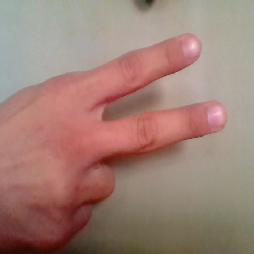

In [47]:
display(image.array_to_img(tar))

In [48]:
pred

array([[9.4234566e-23, 1.0000000e+00, 1.3911631e-28],
       [2.7595483e-17, 2.0496206e-31, 1.0000000e+00],
       [1.0000000e+00, 1.7016311e-27, 0.0000000e+00],
       ...,
       [5.2551965e-12, 1.0000000e+00, 6.9660450e-30],
       [2.9022638e-02, 7.0570013e-07, 9.7097665e-01],
       [1.5991524e-32, 1.0000000e+00, 0.0000000e+00]], dtype=float32)

#Model 2 / T.L. (DenseNet121)


In [49]:
mod = tf.keras.applications.DenseNet121(include_top= False, input_shape= [254,254,3])

In [50]:
# Frezzing Some Layers....

for layer in mod.layers[:400]:
  layer.trainable = False
for layer in mod.layers[400:]:
  layer.trainable = True

In [52]:
# Setting model layers....

mod2 = tf.keras.Sequential([ mod,
                            tf.keras.layers.Flatten(),
                            tf.keras.layers.Dense(512, activation=tf.nn.leaky_relu),
                            tf.keras.layers.Dropout(0.4),
                            tf.keras.layers.Dense(3,activation=tf.nn.softmax),
                            
                            

])

##Compile

In [53]:
mod2.compile(optimizer=tf.optimizers.Adam(),loss=tf.losses.CategoricalCrossentropy(),metrics=['acc'])

##Fitting

In [54]:
mod2_his =mod2.fit(train_data ,epochs=10,batch_size=32,validation_data=test_data)

Epoch 1/10
55/55 [==============================] - 16s 182ms/step - loss: 41.8372 - acc: 0.6776 - val_loss: 1.1839 - val_acc: 0.9703
Epoch 2/10
55/55 [==============================] - 9s 155ms/step - loss: 0.1159 - acc: 0.9952 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 3/10
55/55 [==============================] - 9s 155ms/step - loss: 0.0657 - acc: 0.9965 - val_loss: 0.0189 - val_acc: 0.9977
Epoch 4/10
55/55 [==============================] - 9s 156ms/step - loss: 0.0834 - acc: 0.9974 - val_loss: 0.4301 - val_acc: 0.9909
Epoch 5/10
55/55 [==============================] - 9s 154ms/step - loss: 0.1888 - acc: 0.9958 - val_loss: 0.6554 - val_acc: 0.9909
Epoch 6/10
55/55 [==============================] - 9s 154ms/step - loss: 0.0835 - acc: 0.9956 - val_loss: 0.3866 - val_acc: 0.9886
Epoch 7/10
55/55 [==============================] - 9s 154ms/step - loss: 0.1853 - acc: 0.9968 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 8/10
55/55 [==============================] - 9s 156ms/step - lo

##Predict and evaluate the accuracy

In [55]:
pred2= mod2.predict(x_test)
tf.reduce_mean(tf.metrics.categorical_accuracy(y_test_onehot,pred2))


<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

##Plot loss & val loss

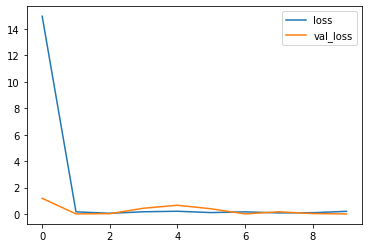

In [56]:
pd.DataFrame(mod2_his.history)[['loss','val_loss']].plot.line()

##Save the model

In [57]:
mod2.save('M_Ameen_RPS_mod2.h5')

In [58]:
sys2 = tf.keras.models.load_model('M_Ameen_RPS_mod2.h5', custom_objects={'leaky_relu': tf.nn.leaky_relu})

##Testing

<IPython.core.display.Javascript object>

Saved to photo.jpg


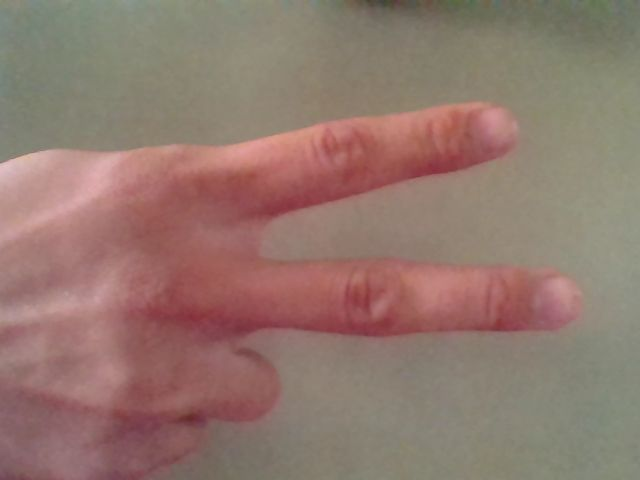

scissors
100.0 %


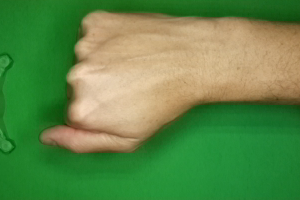

In [67]:
#@title Capturing Photo 2 { vertical-output: true, form-width: "100%", display-mode: "form" }
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename


from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))



photo = '/content/photo.jpg'

tar2 = image.load_img(photo, target_size=(254,254,3))#, color_mode="grayscale")
tar2 = image.img_to_array(tar2)/255.0

pred2=sys2.predict(tf.expand_dims(tar2,0))
hand2 = np.argmax(pred2)

print(labels_dict_rev[hand2])
print(pred2[0][hand2]*100,'%')


#@title Opp. Move { vertical-output: true, form-width: "100%", display-mode: "form" }
if hand2 == 0:   #paper ----> to defet him use sicssor:
  display(image.load_img(os.path.join(path, os.listdir(path)[2], os.listdir(os.path.join(path, os.listdir(path)[2]))[randrange(50)])))
  
elif hand2 == 1:      #Rock ----> to defet him use papper:
  display(image.load_img(os.path.join(path, os.listdir(path)[0], os.listdir(os.path.join(path, os.listdir(path)[0]))[randrange(50)])))

elif hand2 == 2:    #sicssor ----> to defet him use rock:
  display(image.load_img(os.path.join(path, os.listdir(path)[1], os.listdir(os.path.join(path, os.listdir(path)[1]))[randrange(50)])))